In [1]:
import requests
import os
import json
import pprint
from time import sleep
import sched
from datetime import datetime
from time import sleep
import time
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
def clear():
    os.system('cls')

In [3]:
def reqAPI():
    try:
        r = requests.get('https://www.cryptopia.co.nz/api/GetMarkets/BTC')
        coins = json.loads(r.text)['Data']
        if coins is not None:
            return coins #lista de diccionarios 
    except ValueError:
        print('Error al hacer el request, intentando nuevamente')
        reqAPI()

In [4]:
def refreshData():
    #API REQUEST
    lenDic, coc, last, volC, bVol = 0, 0, 0, 0, 0
    ask, bid, spread = 0, 0, 0
    old, recent = 0, 0
    coins = reqAPI()
    while coins is None:
        coins = reqAPI()
        print(type(coins))
    for y in coins:
        changeDic = {}
        name = y['Label']
        if name in dic:
            lenDic = len(dic[name])
        else:
            dic[name] = {}
        ts = datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')
        if y['BidPrice'] != 0:
            spread = ((y['AskPrice']/y['BidPrice'])-1)*100
            spread = round(spread, 2)
        changeDic = {'last':y['LastPrice'],
                    'sprd':spread,
                    'chng':y['Change'],
                    'vol': (0, y['Volume']),
                    'buyVol': (0, y['BuyVolume'])}
        if lenDic != 0: #Si hay registros de precios
            #Cambio
            recent = [*dic[name]][lenDic-1] #Compara con el más reciente
            last = dic[name][recent]['last']
            coc = round((y['LastPrice']/last)-1, 2)
            #Volumen
            last = dic[name][recent]['vol'][1] #Compara el volumen más reciente
            #Captura de los valores viejo y nuevo
            changeDic['vol'] = (last, y['Volume'])
            if last != 0:
                volC = round((y['Volume']/last)-1, 2)
            elif y['Volume'] == 0:
                volC = 0
            else:
                volC = 1
            #BuyVolume
            last = dic[name][recent]['buyVol'][1] #(    ,****) 
            changeDic['buyVol'] = (last, y['BuyVolume'])
            if last != 0:
                bVol = round(y['BuyVolume']/last-1, 2)
            elif y['BuyVolume'] == 0:
                bVol = 0
            else:
                bVol = 1
            changeDic['bvc'] = bVol
            changeDic['coc'] = coc
            changeDic['volC'] = volC
            if coc > 0.05 or volC > 0.05 or bVol > 0.05 : #Si el cambio en precios o en volumen es mayor al 5%
                if not name in toBuy:
                    toBuy[name] = {}
                toBuy[name][ts] = changeDic
                if name not in top: #Si no existe se agrega el primero
                    top[name] = [coc, volC, bVol]
                else: #Compara c/u para buscar el máximo
                    if top[name][0] < coc:
                        top[name][0] = coc
                    if top[name][1] < volC:
                        top[name][1] = volC
                    if top[name][2] < bVol:
                        top[name][2] = bVol
        if lenDic == 5: 
            old = [*dic[name]][0] #Registro más viejo
            dic[name].pop(old)
        #Inserta el nuevo
        dic[name][ts] = changeDic

In [5]:
def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    xpos = xpos.lower()  # normalize the case of the parameter
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off
    ax = plt.gca()
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1.01*height,'{}'.format(height), ha=ha[xpos], va='bottom')

In [6]:
def plotChanges():
    chng, volch, bvolc = [], [], []
    for i in top:
        chng.append(round(top[i][0]*100, 0))
        volch.append(round(top[i][1]*100, 0))
        bvolc.append(round(top[i][2]*100, 0))    

    ind = np.arange(len(chng))  # the x locations for the groups
    width = 0.25  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(ind - width, chng, width, color='SkyBlue', label='Change')
    rects2 = ax.bar(ind, volch, width, color='IndianRed', label='Vol Change')
    rects3 = ax.bar(ind + width, bvolc, width, color='Green', label='Buy Vol Change')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Change %')
    ax.set_title('Cambio en el mercado de cryptos')

    ax.set_xticks(ind)
    ax.set_xticklabels(list(top.keys()))
    ax.legend()

    autolabel(rects1, "center")
    autolabel(rects2, "center")
    autolabel(rects3, "center")

    plt.figure(figsize=(30, 15))
    plt.grid(True, linewidth=0.25)
    plt.show()

In [7]:
def analiza(n):
    url = 'https://www.cryptopia.co.nz/Exchange?market='
    i, suma, toBuySize = 0, 0, 0
    while i <= n:
        start = time.time()
        refreshData()
        end = time.time()
        suma += end-start
        if toBuySize < len(toBuy): #Si se agregó un nvo item a toBuy
            #clear()
            clear_output()
            plotChanges()
            for x in top:
                print(url + x.replace('/', '_'))
            #pp.pprint(toBuy)
        i += 1
        toBuySize = len(toBuy)
        sleep(1.0)

    
    #Tiempo promedio por respuesta
    print('Tiempo promedio de las ejecuciones: ', suma/n)

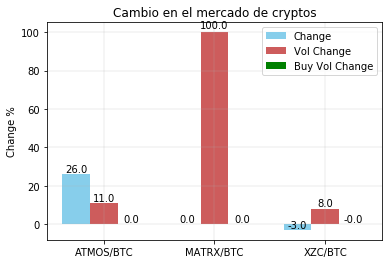

https://www.cryptopia.co.nz/Exchange?market=ATMOS_BTC
https://www.cryptopia.co.nz/Exchange?market=MATRX_BTC
https://www.cryptopia.co.nz/Exchange?market=XZC_BTC
Tiempo promedio de las ejecuciones:  0.6050134897232056


In [12]:
#Coin Analisis
pp = pprint.PrettyPrinter(indent=4)
dic, toBuy, changeDic = {}, {}, {}
top = {}
n = input('Ingresar número de pruebas a ejecutar ')
if type(n) is str:
    n = int(n)
    if n > 0:
        analiza(n)
else:
    print('Ingresa un número mayor a 0')